In [1]:
import cv2
import numpy as np
import torch
import albumentations as albu
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

c:\Users\Богдан\Desktop\summer practice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the classes and image dimensions
CLASSES = ["background", "oil-spill"]
INFER_WIDTH = 256
INFER_HEIGHT = 256

In [3]:
# Define the normalization statistics for ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [4]:
# Define the device to use for computations
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# Define the augmentations
def get_validation_augmentation():
    test_transform = [
        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=1, always_apply=True),
        albu.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
    return albu.Compose(test_transform)

In [52]:
# Load the image
image_path = 'prediction-images/images/test3.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_height, original_width, _ = image.shape

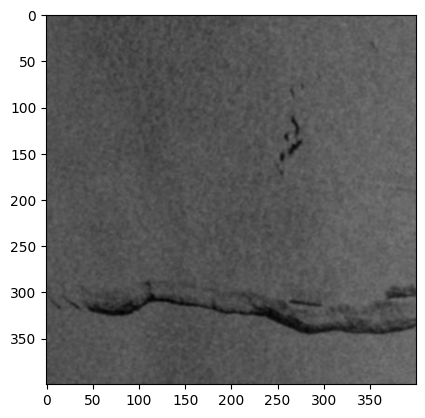

In [53]:
plt.imshow(image)
plt.show()

In [54]:
# Apply the augmentations
augmentation = get_validation_augmentation()
augmented = augmentation(image=image)
image_transformed = augmented['image']

In [55]:
# Convert the image to a PyTorch tensor and move it to the device
x_tensor = torch.from_numpy(image_transformed).to(DEVICE).unsqueeze(0).permute(0, 3, 1, 2).float()

In [56]:
# Load the JIT model
best_model = torch.jit.load('models/best_model_new.pt', map_location=DEVICE)

In [57]:
# Run the image through the model
best_model.eval()
with torch.no_grad():
    pr_mask = best_model(x_tensor)

In [58]:
# Convert the output to a numpy array and remove the batch dimension
pr_mask = pr_mask.squeeze().cpu().detach().numpy()

In [59]:
# Get the class with the highest probability for each pixel
label_mask = np.argmax(pr_mask, axis=0)

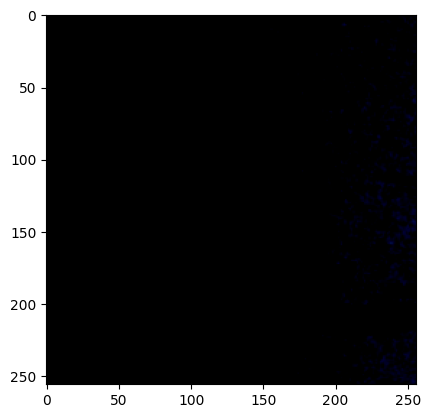

In [60]:
plt.imshow(image_transformed)
plt.show()


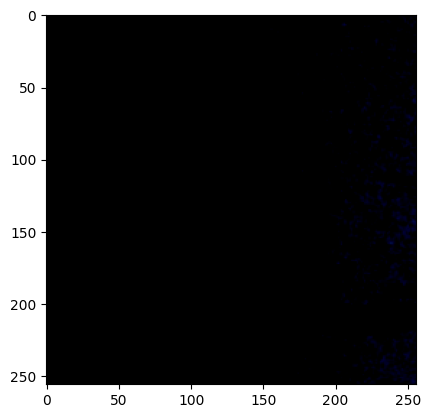

In [61]:

# Опредяем сколько пикселей появится по бокам от паддингов и далее вырежем их
if original_height > original_width:
    delta_pixels = int(((original_height-original_width)/2)/original_height * INFER_HEIGHT)
    print('delta_pixels', delta_pixels)
    image_cropped = image_transformed[:, delta_pixels + 1: INFER_WIDTH - delta_pixels - 1]
    mask_cropped = label_mask[:, delta_pixels + 1 : INFER_WIDTH - delta_pixels - 1]
elif original_height < original_width:
    delta_pixels = int(((original_width-original_height)/2)/original_width * INFER_WIDTH)
    print('delta_pixels', delta_pixels)
    image_cropped = image_transformed[delta_pixels + 1: INFER_HEIGHT - delta_pixels - 1, :]
    mask_cropped = label_mask[delta_pixels + 1: INFER_HEIGHT - delta_pixels - 1, :]
else:
    mask_cropped = label_mask
    image_cropped = image_transformed

plt.imshow(image_cropped)
plt.show()

In [62]:
# Resize the mask back to the original image size
label_mask_real_size = cv2.resize(mask_cropped, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

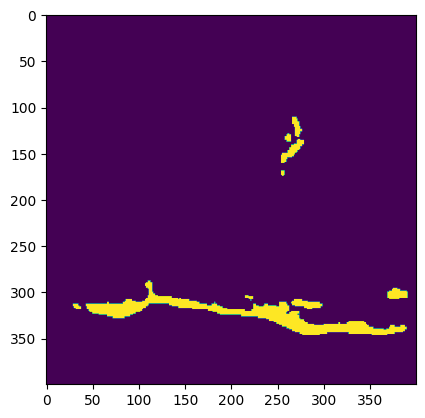

In [63]:
# Print the mask
plt.imshow(label_mask_real_size)
plt.show()